In [17]:
from tqdm import tqdm
import os
import time
from random import randint

import numpy as np
from scipy import stats
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import KFold

import nibabel as nib
import pydicom as pdm
#import nilearn as nl
#import nilearn.plotting as nlplt
import h5py

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.animation as anim
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

import seaborn as sns
import imageio
from skimage.transform import resize
from skimage.util import montage

from IPython.display import Image as show_gif
from IPython.display import clear_output
from IPython.display import YouTubeVideo

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn import MSELoss


import albumentations as A
from albumentations import Compose, HorizontalFlip
from albumentations.pytorch import  ToTensorV2 

import os
import shutil
import tempfile
import time
import matplotlib.pyplot as plt
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader, decollate_batch
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import SegResNet
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
    SpatialCropd
)
from monai.utils import set_determinism
import torch.nn as nn
from monai.losses import DiceLoss
import torch


import warnings
warnings.simplefilter("ignore")

In [1]:
import sys
sys.path.append("..")

from models import UNet3d, AttnUNet3d
from loss_metric import *
from dataset_dataloader import *
from trainer import Trainer

In [2]:
class GlobalConfig:
    root_dir = '/home/mandrakedrink/edu/data'
    train_root_dir = 'home/mandrakedrink/edu/brats2021'
    test_root_dir = 'home/mandrakedrink/edu/brats2021'
    path_to_train_csv = '/home/mandrakedrink/edu/dyplom_work/brats2020/unet_att/train.csv'
    path_to_test_csv = '/home/mandrakedrink/edu/dyplom_work/brats2020/unet_att/test.csv'
    pretrained_model_path = '/home/mandrakedrink/edu/dyplom_work/brats2020/unet_att/best_model_27.pth'
    train_logs_path = '/home/mandrakedrink/edu/dyplom_work/brats2020/unet_att/train_log.csv'
    seed = 55
    
def seed_everything(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    
config = GlobalConfig()
seed_everything(config.seed)

In [3]:
path = os.listdir("/home/mandrakedrink/edu/brats2021")
path.remove(".DS_Store")
df = pd.DataFrame(path, columns=['Brats20ID'])
df['path'] = df['Brats20ID'].apply(lambda x : "/home/mandrakedrink/edu/brats2021/" + x )
df

,Brats20ID,path
0,BraTS2021_00194,/home/mandrakedrink/edu/brats2021/BraTS2021_00194
1,BraTS2021_00804,/home/mandrakedrink/edu/brats2021/BraTS2021_00804
2,BraTS2021_01597,/home/mandrakedrink/edu/brats2021/BraTS2021_01597
3,BraTS2021_00840,/home/mandrakedrink/edu/brats2021/BraTS2021_00840
4,BraTS2021_01133,/home/mandrakedrink/edu/brats2021/BraTS2021_01133
...,...,...
1246,BraTS2021_00744,/home/mandrakedrink/edu/brats2021/BraTS2021_00744
1247,BraTS2021_01140,/home/mandrakedrink/edu/brats2021/BraTS2021_01140
1248,BraTS2021_01080,/home/mandrakedrink/edu/brats2021/BraTS2021_01080
1249,BraTS2021_00568,/home/mandrakedrink/edu/brats2021/BraTS2021_00568


# Data Visualization + Augmentations

In [4]:
sample_filename = '/home/mandrakedrink/edu/brats2021/BraTS2021_00194/BraTS2021_00194' + '_flair.nii.gz'
sample_filename_mask = '/home/mandrakedrink/edu/brats2021/BraTS2021_00194/BraTS2021_00194' + '_seg.nii.gz'

sample_img = nib.load(sample_filename)
sample_img = np.asanyarray(sample_img.dataobj)
sample_img = np.rot90(sample_img)
sample_mask = nib.load(sample_filename_mask)
sample_mask = np.asanyarray(sample_mask.dataobj)
sample_mask = np.rot90(sample_mask)
print("img shape ->", sample_img.shape)
print("mask shape ->", sample_mask.shape)

img shape -> (240, 240, 155)
mask shape -> (240, 240, 155)


In [5]:
sample_filename2 = '/home/mandrakedrink/edu/brats2021/BraTS2021_00194/BraTS2021_00194' + '_t1.nii.gz'
sample_img2 = nib.load(sample_filename2)
sample_img2 = np.asanyarray(sample_img2.dataobj)
sample_img2  = np.rot90(sample_img2)

sample_filename3 = '/home/mandrakedrink/edu/brats2021/BraTS2021_00194/BraTS2021_00194' + '_t2.nii.gz'
sample_img3 = nib.load(sample_filename3)
sample_img3 = np.asanyarray(sample_img3.dataobj)
sample_img3  = np.rot90(sample_img3)

sample_filename4 = '/home/mandrakedrink/edu/brats2021/BraTS2021_00194/BraTS2021_00194' + '_t1ce.nii.gz'
sample_img4 = nib.load(sample_filename4)
sample_img4 = np.asanyarray(sample_img4.dataobj)
sample_img4  = np.rot90(sample_img4)

mask_WT = sample_mask.copy()
mask_WT[mask_WT == 1] = 1
mask_WT[mask_WT == 2] = 0
mask_WT[mask_WT == 4] = 0

mask_TC = sample_mask.copy()
mask_TC[mask_TC == 1] = 0
mask_TC[mask_TC == 2] = 1
mask_TC[mask_TC == 4] = 0

mask_ET = sample_mask.copy()
mask_ET[mask_ET == 1] = 0
mask_ET[mask_ET == 2] = 0
mask_ET[mask_ET == 4] = 1

#... the GD-enhancing tumor (ET — label 4), the peritumoral edematous/invaded tissue (ED — label 2), and the necrotic tumor core (NCR — label 1).

#and the Necrotic tumor core (NCR — label 1). 
#the peritumoral edematous/invaded tissue 
#(ED — label 2) the GD-enhancing tumor (ET — label 4),


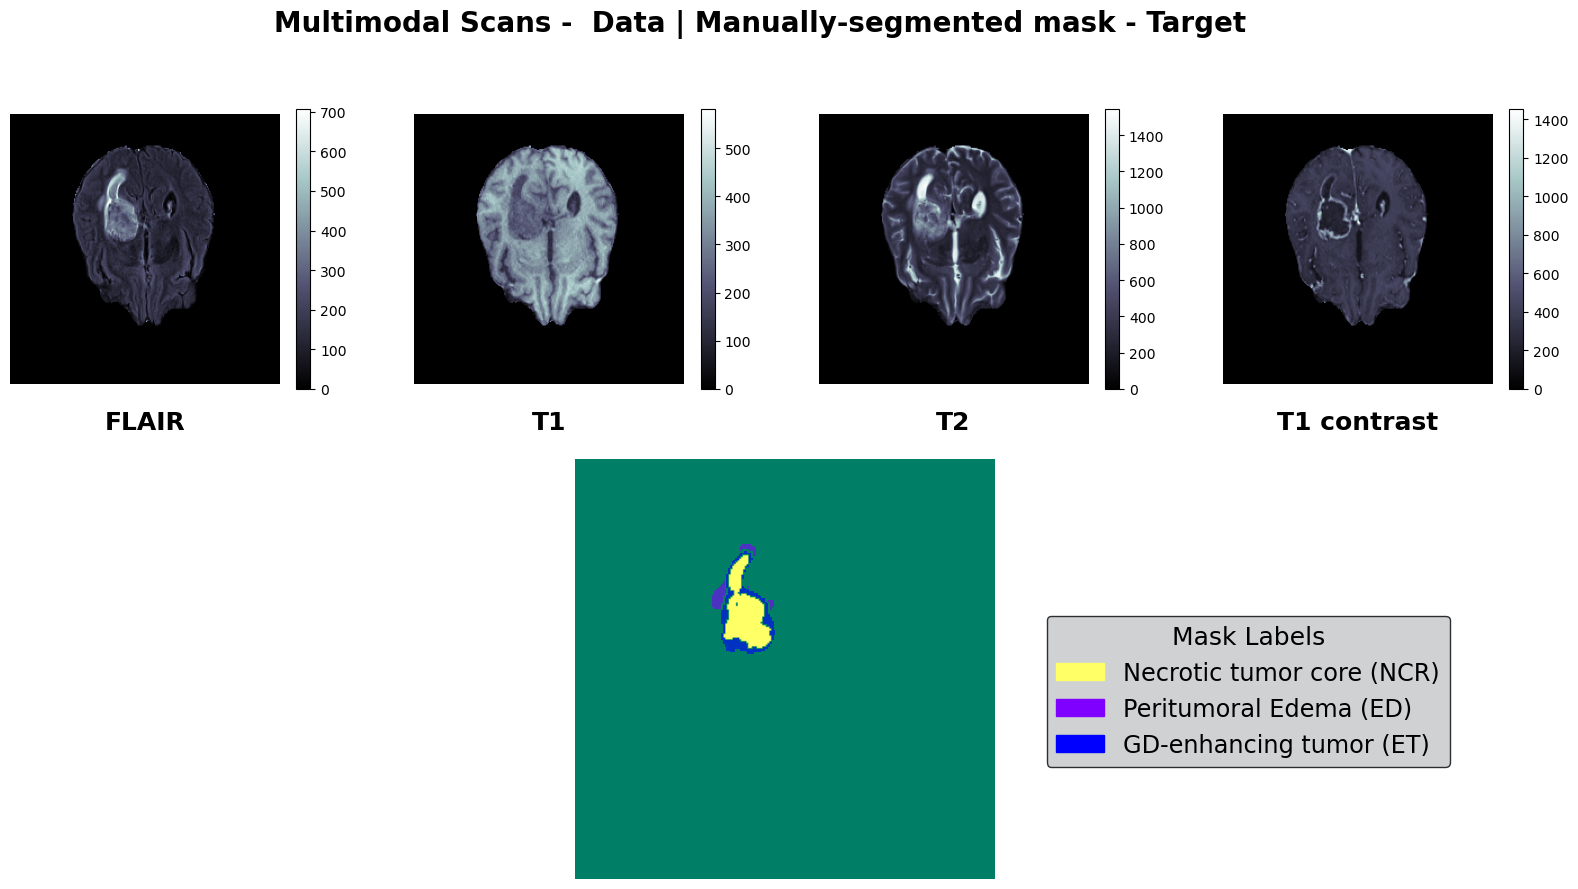

In [6]:
# https://matplotlib.org/3.3.2/gallery/images_contours_and_fields/plot_streamplot.html#sphx-glr-gallery-images-contours-and-fields-plot-streamplot-py
# https://stackoverflow.com/questions/25482876/how-to-add-legend-to-imshow-in-matplotlib
fig = plt.figure(figsize=(20, 10))

gs = gridspec.GridSpec(nrows=2, ncols=4, height_ratios=[1, 1.5])

#  Varying density along a streamline
ax0 = fig.add_subplot(gs[0, 0])
flair = ax0.imshow(sample_img[:,:,65], cmap='bone')
ax0.set_title("FLAIR", fontsize=18, weight='bold', y=-0.2)
fig.colorbar(flair)

#  Varying density along a streamline
ax1 = fig.add_subplot(gs[0, 1])
t1 = ax1.imshow(sample_img2[:,:,65], cmap='bone')
ax1.set_title("T1", fontsize=18, weight='bold', y=-0.2)
fig.colorbar(t1)

#  Varying density along a streamline
ax2 = fig.add_subplot(gs[0, 2])
t2 = ax2.imshow(sample_img3[:,:,65], cmap='bone')
ax2.set_title("T2", fontsize=18, weight='bold', y=-0.2)
fig.colorbar(t2)

#  Varying density along a streamline
ax3 = fig.add_subplot(gs[0, 3])
t1ce = ax3.imshow(sample_img4[:,:,65], cmap='bone')
ax3.set_title("T1 contrast", fontsize=18, weight='bold', y=-0.2)
fig.colorbar(t1ce)

#  Varying density along a streamline
ax4 = fig.add_subplot(gs[1, 1:3])

#ax4.imshow(np.ma.masked_where(mask_WT[:,:,65]== False,  mask_WT[:,:,65]), cmap='summer', alpha=0.6)
l1 = ax4.imshow(mask_WT[:,:,65], cmap='summer',)
l2 = ax4.imshow(np.ma.masked_where(mask_TC[:,:,65]== False,  mask_TC[:,:,65]), cmap='rainbow', alpha=0.6)
l3 = ax4.imshow(np.ma.masked_where(mask_ET[:,:,65] == False, mask_ET[:,:,65]), cmap='winter', alpha=0.6)

ax4.set_title("", fontsize=20, weight='bold', y=-0.1)

_ = [ax.set_axis_off() for ax in [ax0,ax1,ax2,ax3, ax4]]

colors = [im.cmap(im.norm(1)) for im in [l1,l2, l3]]
labels = ['Necrotic tumor core (NCR)', 'Peritumoral Edema (ED)', 'GD-enhancing tumor (ET)']
patches = [ mpatches.Patch(color=colors[i], label=f"{labels[i]}") for i in range(len(labels))]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.1, 0.65), loc=2, borderaxespad=0.4,fontsize = 'xx-large',
           title='Mask Labels', title_fontsize=18, edgecolor="black",  facecolor='#c5c6c7')

plt.suptitle("Multimodal Scans -  Data | Manually-segmented mask - Target", fontsize=20, weight='bold')

fig.savefig("data_sample.png", format="png",  pad_inches=0.2, transparent=False, bbox_inches='tight')
fig.savefig("data_sample.svg", format="svg",  pad_inches=0.2, transparent=False, bbox_inches='tight')

In [7]:
train_transform = Compose(
    [
        # load 4 Nifti images and stack them together
        #LoadImaged(keys=["image", "label"]),
        #EnsureChannelFirstd(keys="image"),
        #EnsureTyped(keys=["image", "label"]),
        #ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        RandSpatialCropd(keys=["image", "label"], roi_size=[224, 224, 144], random_size=False),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
    ]
)

In [8]:
"""        images = []
        for data_type in self.data_types:
            img_path = os.path.join(root_path, id_ + data_type)
            img = self.load_img(img_path)#.transpose(2, 0, 1)
            
            if self.is_resize:
                img = self.resize(img)
    
            img = self.normalize(img)
            images.append(img)
        img = np.stack(images)
        img = np.moveaxis(img, (0, 1, 2, 3), (0, 3, 2, 1))"""

'        images = []\n        for data_type in self.data_types:\n            img_path = os.path.join(root_path, id_ + data_type)\n            img = self.load_img(img_path)#.transpose(2, 0, 1)\n            \n            if self.is_resize:\n                img = self.resize(img)\n    \n            img = self.normalize(img)\n            images.append(img)\n        img = np.stack(images)\n        img = np.moveaxis(img, (0, 1, 2, 3), (0, 3, 2, 1))'

In [9]:
mask = np.stack([mask_WT, mask_TC, mask_ET])
mask = np.moveaxis(mask, (0, 1, 2, 3), (0, 3, 2, 1))
mask.shape

(3, 155, 240, 240)

In [10]:
images = []
images.extend([sample_img, sample_img2, sample_img3, sample_img4])
image = np.stack(images)
image = np.moveaxis(image, (0, 1, 2, 3), (0, 3, 2, 1))
image.shape

(4, 155, 240, 240)

In [11]:
train_transform = Compose(
    [
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        RandSpatialCropd(keys=["image", "label"], roi_size=[224, 224, 144], random_size=False),

    ]
)

In [12]:
data = {'image': image, 'label': mask}
aug_data = train_transform(data)

In [13]:
aug_data['image'].shape, aug_data['label'].shape

(torch.Size([4, 155, 224, 144]), torch.Size([3, 155, 224, 144]))

In [14]:
aug_img = aug_data['image'].permute(0, 2, 3, 1)
aug_mask = aug_data['label'].permute(0, 2, 3, 1)
orig_img = image.transpose((0, 2, 3, 1))

In [15]:
aug_img.shape, orig_img.shape, aug_mask.shape

(torch.Size([4, 224, 144, 155]),
 (4, 240, 240, 155),
 torch.Size([3, 224, 144, 155]))

In [18]:
train_transform1 = Compose(
    [
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        RandSpatialCropd(keys=["image", "label"], roi_size=[224, 224, 144], random_size=False),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
    ]
)

train_transform1 = Compose(
    [
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        SpatialCropd(keys=["image", "label"], roi_size=[224, 224, 144],roi_center=[77, 120, 120]),
        #RandFlipd(keys=["image", "label"], prob=1.0, spatial_axis=0),
    ]
)



train_transform2 = Compose(
    [

        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        #patialCropd(keys=["image", "label"], roi_size=[224, 224, 144], roi_center=[77, 120, 120]),
        RandFlipd(keys=["image", "label"], prob=1.0, spatial_axis=0),
    ]
)

train_transform3 = Compose(
    [

        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        RandFlipd(keys=["image", "label"], prob=1.0, spatial_axis=1),
    ]
)

train_transform4 = Compose(
    [

        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        RandFlipd(keys=["image", "label"], prob=1.0, spatial_axis=2),
    ]
)

train_transform5 = Compose(
    [
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        RandScaleIntensityd(keys="image", factors=0.3, prob=1.0),
    ]
) 

train_transform6 = Compose(
    [
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        RandShiftIntensityd(keys="image", offsets=0.3, prob=1.0),
    ]
)

In [19]:

orig_img = image.transpose((0, 2, 3, 1))
orig_mask = mask.transpose((0, 2, 3, 1))
print(orig_img.shape, orig_mask.shape)

(4, 240, 240, 155) (3, 240, 240, 155)


In [20]:
data = {'image': image, 'label': mask}
aug_data = train_transform(data)

In [22]:
aug1_img = train_transform1(data)['image'].permute(0, 2, 3, 1)
aug1_mask = train_transform1(data)['label'].permute(0, 2, 3, 1)

aug2_img = train_transform2(data)['image'].permute(0, 2, 3, 1)
aug2_mask = train_transform2(data)['label'].permute(0, 2, 3, 1)

aug3_img = train_transform3(data)['image'].permute(0, 2, 3, 1)
aug3_mask = train_transform3(data)['label'].permute(0, 2, 3, 1)


aug4_img = train_transform4(data)['image'].permute(0, 2, 3, 1)
aug4_mask = train_transform4(data)['label'].permute(0, 2, 3, 1)

aug5_img = train_transform5(data)['image'].permute(0, 2, 3, 1)
aug5_mask = train_transform5(data)['label'].permute(0, 2, 3, 1)

aug6_img = train_transform6(data)['image'].permute(0, 2, 3, 1)
aug6_mask = train_transform6(data)['label'].permute(0, 2, 3, 1)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


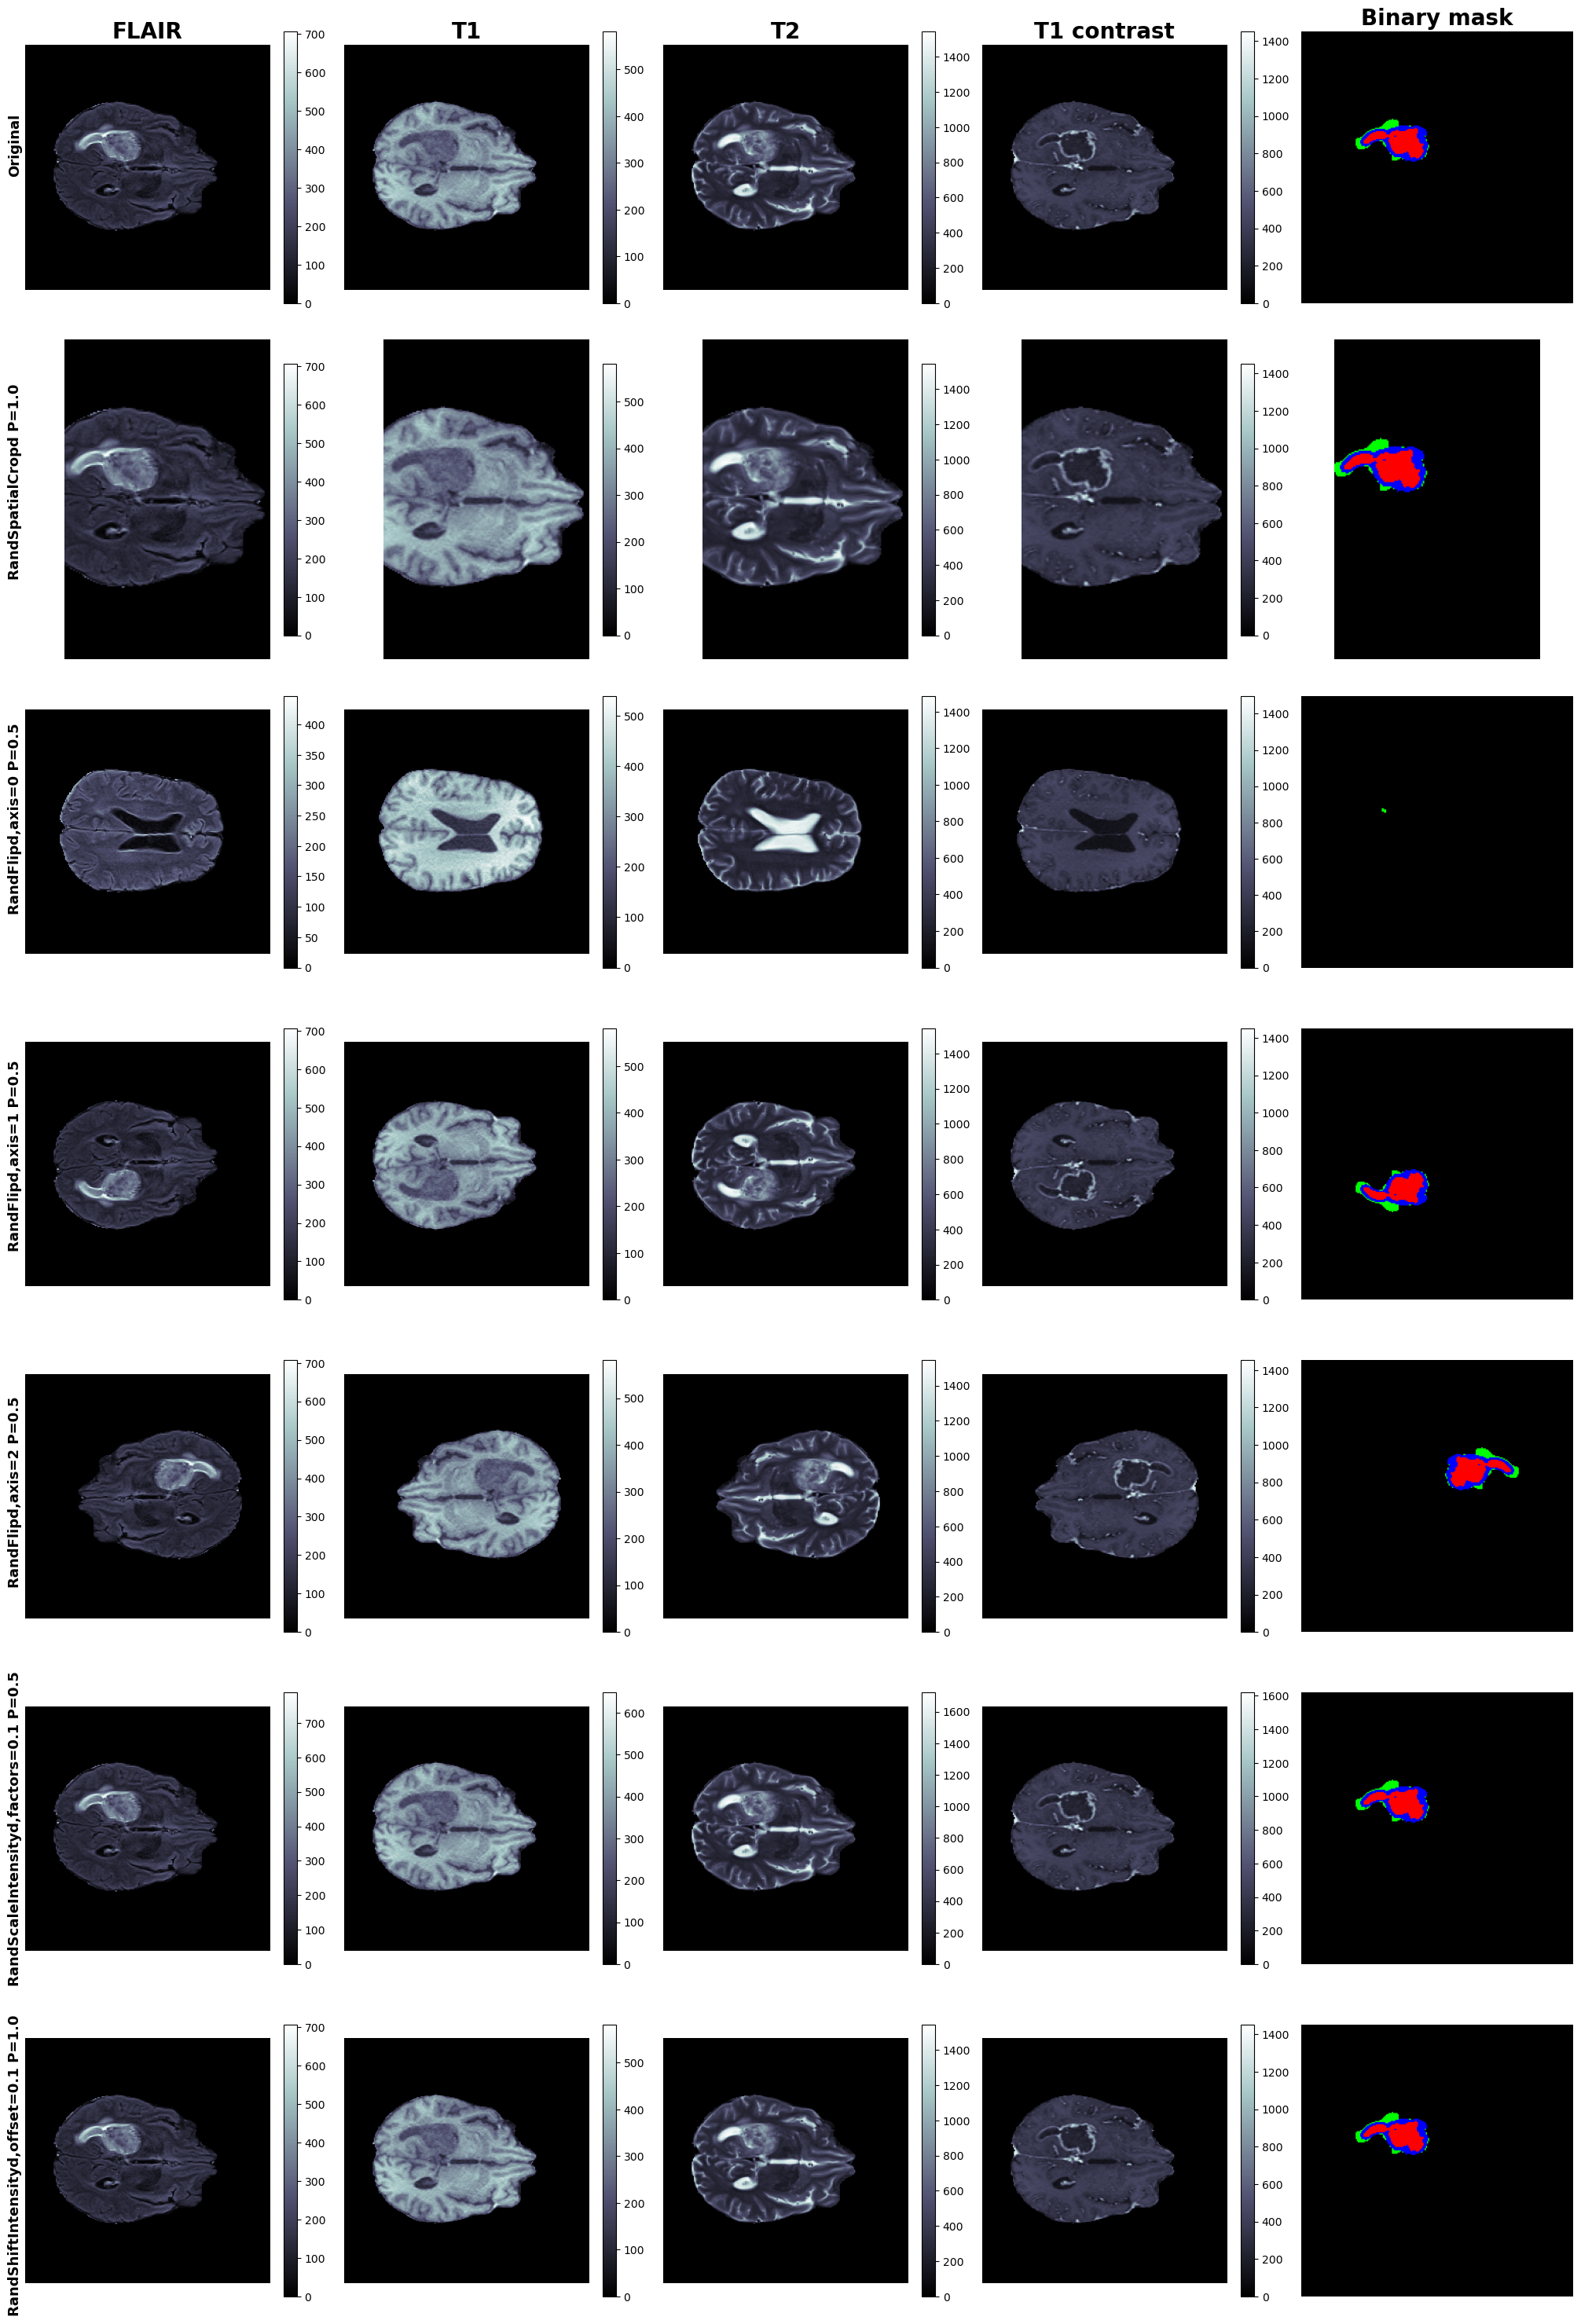

In [23]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_rows(rows, masks, titles1, titles2):
    #assert len(row1) == len(row2) == len(row3) == len(row4) == 4, "Provide exactly 4 images for each row."

    fig, axs = plt.subplots(7, 5, figsize=(20, 30))

    # Увеличиваем пространство между рядами
    plt.subplots_adjust(hspace=0.3, wspace=0.3)

    #rows = [row1, row2, row3, row4]

    # Добавляем заголовки для рядов слева
    for idx, title in enumerate(titles2):
        #fig.text(0.001, 0.88 - idx*0.25, title, ha='center', va='center', fontsize=15, rotation='vertical', weight="bold")
        fig.text(0.001, 1 - (idx + 0.5)/len(rows), title, ha='center', va='center', fontsize=13, rotation='vertical', weight="bold")


    for row_idx, row in enumerate(rows):
            
        for col_idx, img in enumerate(row):
            im = axs[row_idx, col_idx].imshow(img, cmap='bone')
            axs[row_idx, col_idx].axis('off')
            fig.colorbar(im, ax=axs[row_idx, col_idx], orientation='vertical', fraction=.05)
            if row_idx == 0:
                axs[row_idx, col_idx].set_title(titles1[col_idx], weight="bold", fontsize=20)
            #if col_idx == 0:
               # axs[row_idx, col_idx].set_ylabel(titles[row_idx], fontsize=15, rotation='vertical', weight="bold", color="blue")
               # axs[row_idx, col_idx].yaxis.set_label_coords(-0.3,0.5)
        
        # masks
        mask = masks[row_idx].permute(1,2,0) if isinstance(masks[row_idx], torch.Tensor) else masks[row_idx].transpose(1,2,0) * 255.
        im = axs[row_idx, 4].imshow(mask)
        axs[row_idx, col_idx+1].axis('off')
        #fig.colorbar(im, ax=axs[row_idx, col_idx+1], orientation='vertical', fraction=.05)
        if row_idx == 0:
            axs[row_idx, col_idx+1].set_title(titles1[col_idx+1], weight="bold", fontsize=20)
            
    plt.tight_layout(h_pad=1)
    # Сохранение изображения
    plt.savefig(f"aug_data.png", transparent=False, bbox_inches='tight')
    plt.savefig(f"aug_data.svg", transparent=False, bbox_inches='tight')
    plt.show()


titles2 = ['Original','RandSpatialCropd P=1.0', 'RandFlipd,axis=0 P=0.5', 'RandFlipd,axis=1 P=0.5', 'RandFlipd,axis=2 P=0.5', 'RandScaleIntensityd,factors=0.1 P=0.5', 'RandShiftIntensityd,offset=0.1 P=1.0',   ]
titles1 = ['FLAIR','T1','T2','T1 contrast', 'Binary mask']
masks = [
    orig_mask[:,:,:,65], 
    aug1_mask[:,:,:,65],
    aug2_mask[:,:,:,65],
    aug3_mask[:,:,:,65],
    aug4_mask[:,:,:,65],
    aug5_mask[:,:,:,65],
    aug6_mask[:,:,:,65],
]

images = [orig_img[:,:,:,65], 
          aug1_img[:,:,:,65],
          aug2_img[:,:,:,65], 
          aug3_img[:,:,:,65],
          aug4_img[:,:,:,65],
          aug5_img[:,:,:,65],
          aug6_img[:,:,:,65]
         ]

visualize_rows(images, masks,  titles1, titles2)


# Next One

Num uniq Image values : 728
Min/Max Image values: 0.0 820.0
Num uniq Mask values: (array([0., 1.], dtype=float32), array([4985411,   14269]))


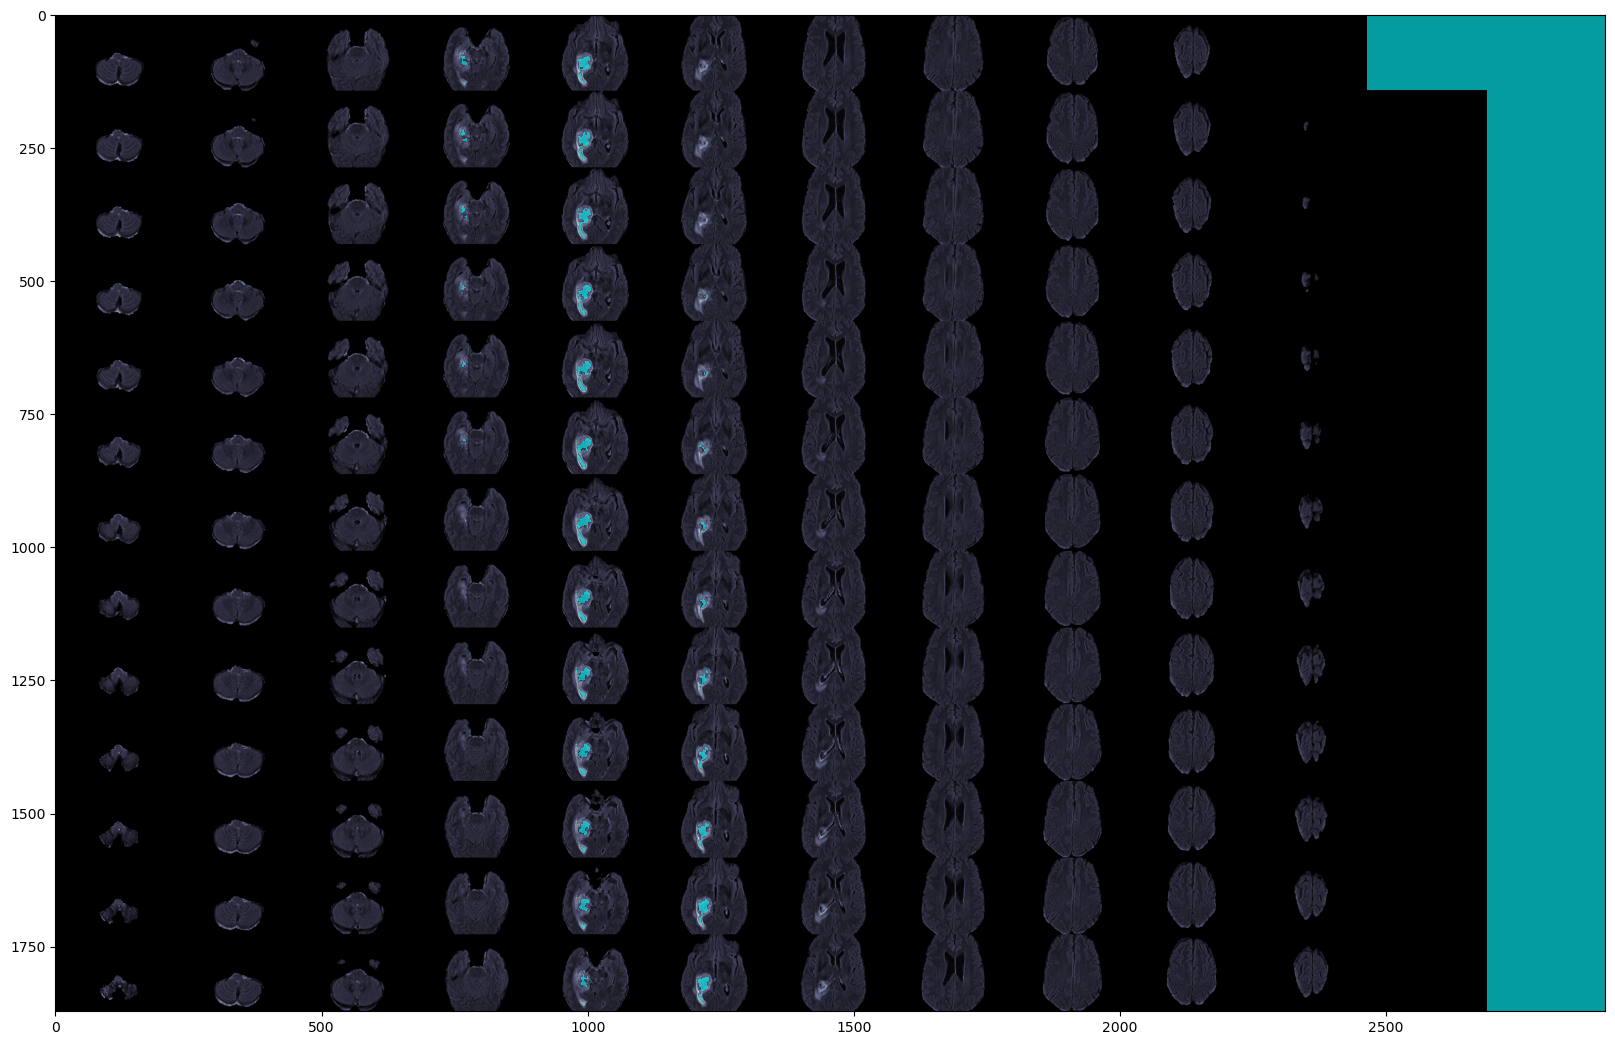

In [26]:
img_tensor = aug_data['image'].squeeze()[0].cpu().detach().numpy() 
mask_tensor = aug_data['label'].squeeze()[0].squeeze().cpu().detach().numpy()
print("Num uniq Image values :", len(np.unique(img_tensor, return_counts=True)[0]))
print("Min/Max Image values:", img_tensor.min(), img_tensor.max())
print("Num uniq Mask values:", np.unique(mask_tensor, return_counts=True))

image = np.rot90(montage(img_tensor))
mask = np.rot90(montage(mask_tensor)).astype(bool)

fig, ax = plt.subplots(1, 1, figsize = (20, 20))
ax.imshow(image, cmap ='bone')
ax.imshow(np.ma.masked_where(mask == False, mask),
           cmap='cool', alpha=0.6)
plt.show()

# Another One

In [27]:
df

,Brats20ID,path
0,BraTS2021_00194,/home/mandrakedrink/edu/brats2021/BraTS2021_00194
1,BraTS2021_00804,/home/mandrakedrink/edu/brats2021/BraTS2021_00804
2,BraTS2021_01597,/home/mandrakedrink/edu/brats2021/BraTS2021_01597
3,BraTS2021_00840,/home/mandrakedrink/edu/brats2021/BraTS2021_00840
4,BraTS2021_01133,/home/mandrakedrink/edu/brats2021/BraTS2021_01133
...,...,...
1246,BraTS2021_00744,/home/mandrakedrink/edu/brats2021/BraTS2021_00744
1247,BraTS2021_01140,/home/mandrakedrink/edu/brats2021/BraTS2021_01140
1248,BraTS2021_01080,/home/mandrakedrink/edu/brats2021/BraTS2021_01080
1249,BraTS2021_00568,/home/mandrakedrink/edu/brats2021/BraTS2021_00568


In [ ]:
"""import os
import numpy as np
import nibabel as nib
import pandas as pd

def compute_tumor_areas(mask):
    # BRATS классы: 0 - фон, 1 - некротический и неактивный опухоль, 2 - отек, 3 - enhancing tumor
    areas = [np.sum(mask == i) for i in range(4)]
    return areas

def load_img(self, file_path):
        data = nib.load(file_path)
        data = np.asarray(data.dataobj)
        return data
    
    
# Папки с изображениями и масками
image_dir = 'path_to_brats_data/images'
mask_dir = 'path_to_brats_data/masks'

# Список файлов
image_files = os.listdir(image_dir)
mask_files = os.listdir(mask_dir)

data = []

for image_file, mask_file in zip(image_files, mask_files):
    # Загрузка изображения и маски
    image_path = os.path.join(image_dir, image_file)
    mask_path = os.path.join(mask_dir, mask_file)
    
    image = nib.load(image_path).get_fdata()
    mask = nib.load(mask_path).get_fdata()

    # Рассчитываем площадь для каждого класса
    areas = compute_tumor_areas(mask)
    data.append([image_file] + areas)

# Создание и сохранение датафрейма
df = pd.DataFrame(data, columns=['Image', 'Background', 'Necrotic', 'Edema', 'Enhancing'])
df.to_csv('tumor_areas.csv', index=False)""";


In [28]:
import os
import numpy as np
import nibabel as nib
import pandas as pd
from skimage.filters import threshold_otsu

def compute_tumor_areas(mask):
    # BRATS классы: 0 - фон, 1 - некротический и неактивный опухоль, 2 - отек, 4 - enhancing tumor
    areas = [np.sum(mask == i) for i in [1 ,2, 4]]
    return areas

def load_img( file_path, fdata=False):
        img = nib.load(file_path)
        #img = np.asarray(img.dataobj)
        if fdata:
            data = img.get_fdata()
            return img, data
        return np.asarray(img.dataobj)
    

data_info = []

for index, row in df.iterrows():
    path_mask = os.path.join(row['path'], row['Brats20ID'] + "_seg.nii.gz")
    path_img = os.path.join(row['path'], row['Brats20ID'] + "_t1.nii.gz")
    
    # mask
    mask = load_img(path_mask)
    areas = compute_tumor_areas(mask)
    
    # img
    img, data  = load_img(path_img, True)
    threshold_value = threshold_otsu(data)
    thresholded_data = (data > threshold_value).astype(int)
    
    #  объем
    voxel_volume = np.prod(img.header.get_zooms())  # Объем одного вокселя
    brain_volume = np.sum(thresholded_data) * voxel_volume
    
    data_info.append([row['Brats20ID']] + [thresholded_data.sum()] +  areas + [brain_volume])
    
# Создание и сохранение датафрейма
df = pd.DataFrame(data_info, columns=['Brats20ID', 'Brain', 'Necrotic tumor core (NCR)', 'Peritumoral Edema (ED)', 'GD-enhancing tumor (ET)', 'Brain Volume'])#labels = ['Necrotic tumor core (NCR)', 'Peritumoral Edema (ED)', 'GD-enhancing tumor (ET)']

df.to_csv('tumor_areas.csv', index=False)
#merged_df = df.merge(df_, on='Brats20ID', how='inner')

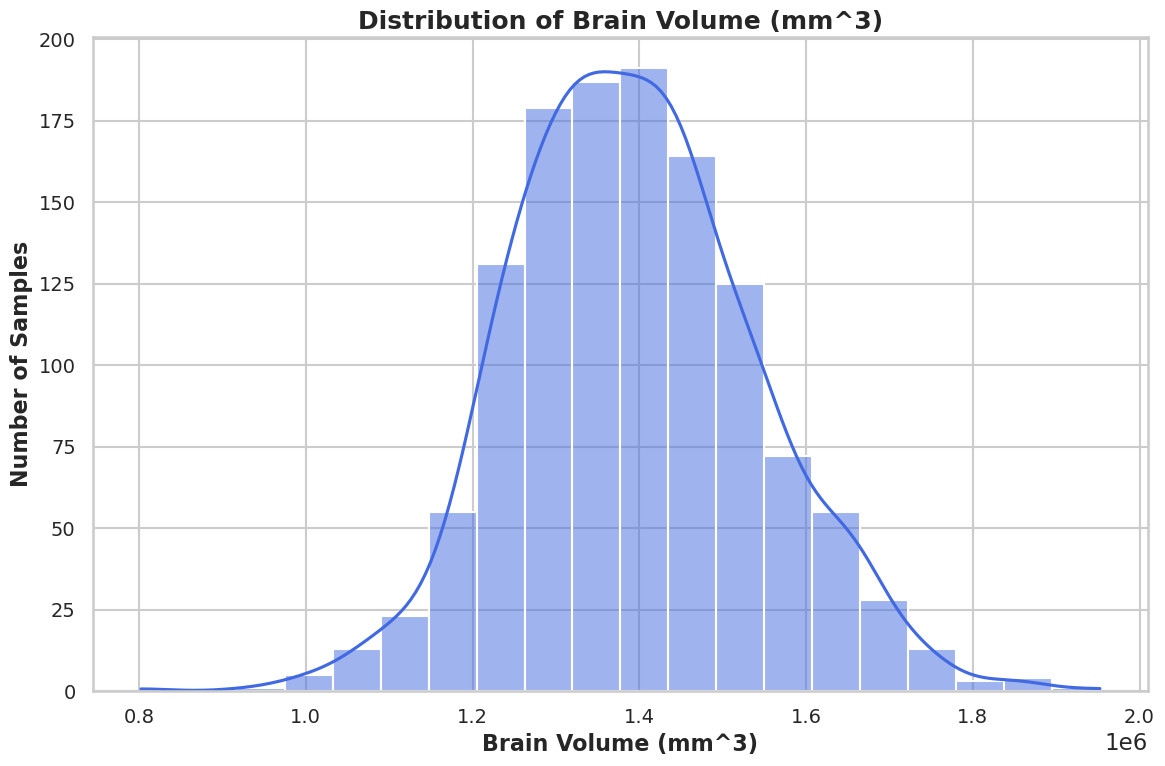

In [342]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



# Установка стиля и контекста для "seaborn"
sns.set_style("whitegrid")
sns.set_context("talk") # "talk" подходит для презентаций/статей

plt.figure(figsize=(12,8))

# Визуализация
sns.histplot(df['Brain Volume'], bins=20, color='royalblue', kde=True)
plt.title('Distribution of Brain Volume (mm^3)', fontsize=18, weight='bold')
plt.xlabel('Brain Volume (mm^3)', fontsize=16, weight='bold')
plt.ylabel('Number of Samples', fontsize=16, weight='bold')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.show()


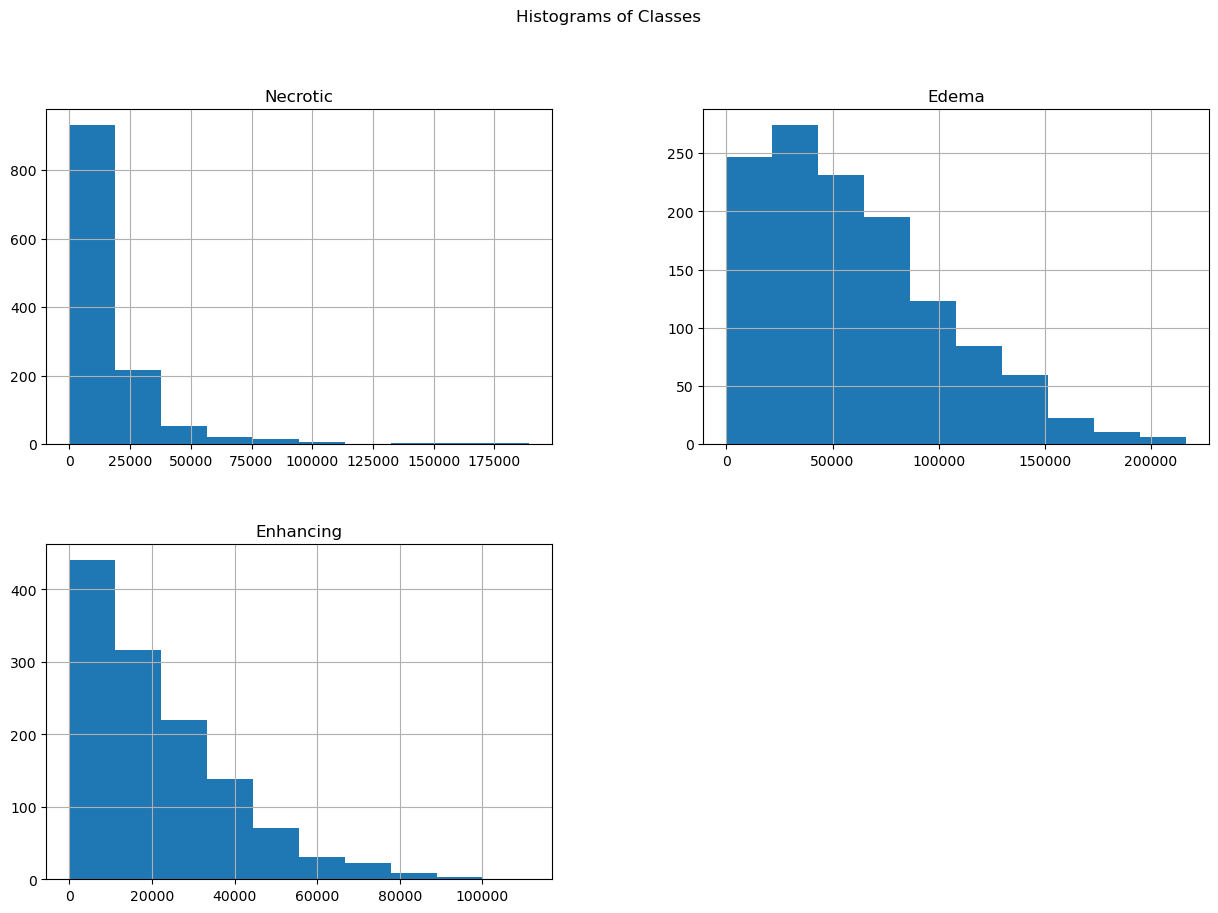

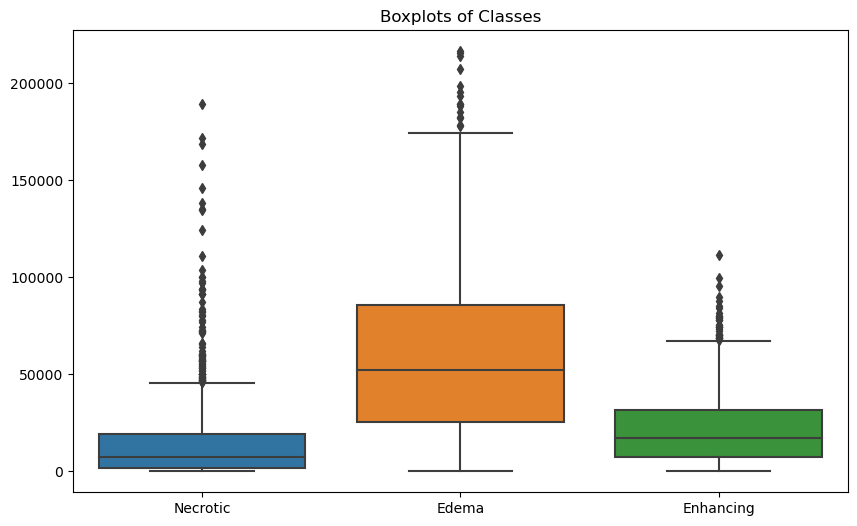

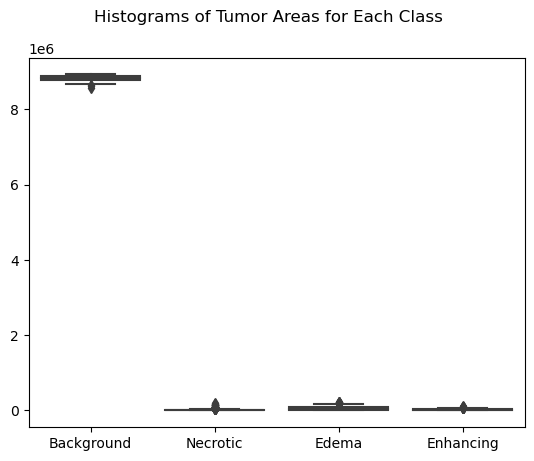

In [236]:
import seaborn as sns
import matplotlib.pyplot as plt

# Гистограммы
df[['Necrotic', 'Edema', 'Enhancing']].hist(figsize=(15,10))
plt.suptitle('Histograms of Classes')
plt.show()

# Ящики с усами
plt.figure(figsize=(10,6))
sns.boxplot(data=df[['Necrotic', 'Edema', 'Enhancing']])
plt.title('Boxplots of Classes')
plt.show()

import matplotlib.pyplot as plt
import seaborn as sns

# Гистограммы для каждого класса
sns.boxplot(data=df[['Background', 'Necrotic', 'Edema', 'Enhancing']])
plt.suptitle('Histograms of Tumor Areas for Each Class')
plt.show()



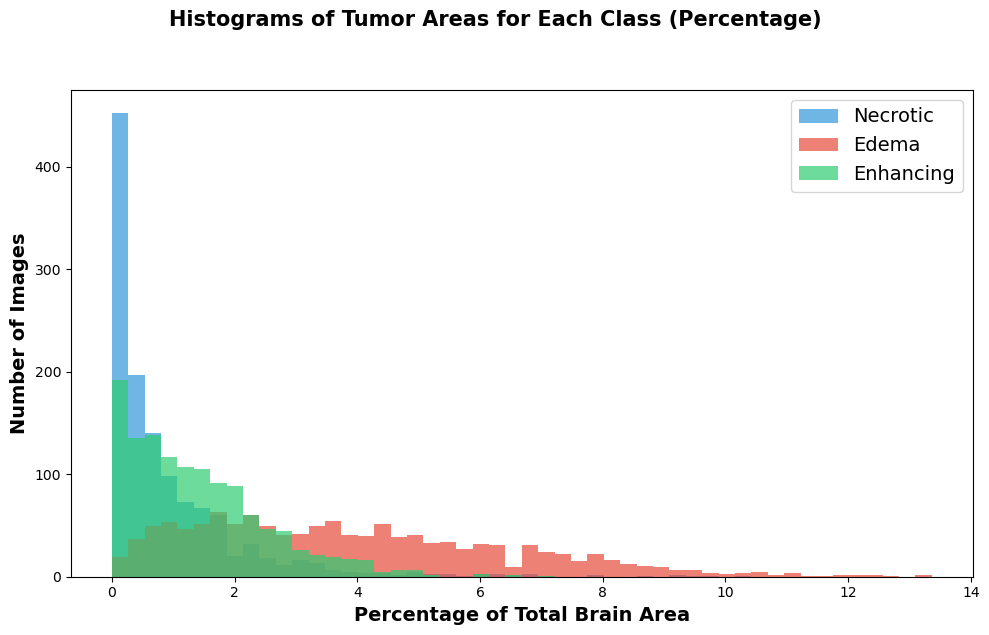

In [40]:
# Нормализация данных
# Нормализация данных
df_normalized = df.copy()

total_area = df['Necrotic tumor core (NCR)'] + df['Peritumoral Edema (ED)'] + df['GD-enhancing tumor (ET)'] + df['Brain']

df_normalized['Necrotic'] = (df['Necrotic tumor core (NCR)'] / total_area) * 100
df_normalized['Edema'] = (df['Peritumoral Edema (ED)'] / total_area) * 100
df_normalized['Enhancing'] = (df['GD-enhancing tumor (ET)'] / total_area) * 100

# Гистограммы для каждого класса после нормализации
colors = ["#3498db", "#e74c3c", "#2ecc71"]  # Голубой, красный, зеленый
df_normalized[['Necrotic', 'Edema', 'Enhancing']].plot(kind='hist', figsize=(10,6), bins=50, color=colors, alpha=0.7)

plt.suptitle('Histograms of Tumor Areas for Each Class (Percentage)', fontsize=15, y=1.05, weight='bold')
plt.xlabel('Percentage of Total Brain Area', fontsize=14, weight='bold')
plt.ylabel('Number of Images', fontsize=14, weight='bold')
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()



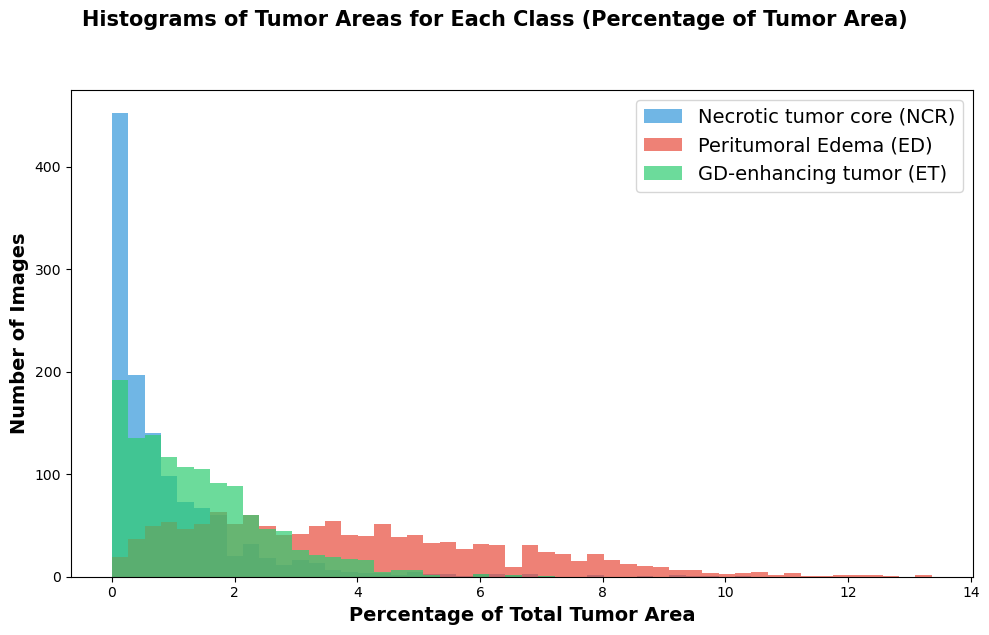

In [34]:
# Нормализация данных
df_normalized = df.copy()

total_tumor_area = df['Necrotic'] + df['Edema'] + df['Enhancing']

df_normalized['Necrotic'] = (df['Necrotic'] / total_tumor_area) * 100
df_normalized['Edema'] = (df['Edema'] / total_tumor_area) * 100
df_normalized['Enhancing'] = (df['Enhancing'] / total_tumor_area) * 100

# Гистограммы для каждого класса после нормализации
colors = ["#3498db", "#e74c3c", "#2ecc71"]  # Голубой, красный, зеленый
df_normalized[['Necrotic', 'Edema', 'Enhancing']].plot(kind='hist', figsize=(10,6), bins=50, color=colors, alpha=0.7)

plt.suptitle('Histograms of Tumor Areas for Each Class (Percentage of Tumor Area)', fontsize=15, y=1.05, weight='bold')
plt.xlabel('Percentage of Total Tumor Area', fontsize=14, weight='bold')
plt.ylabel('Number of Images', fontsize=14, weight='bold')
plt.legend(fontsize=14,)
plt.tight_layout()
plt.show()


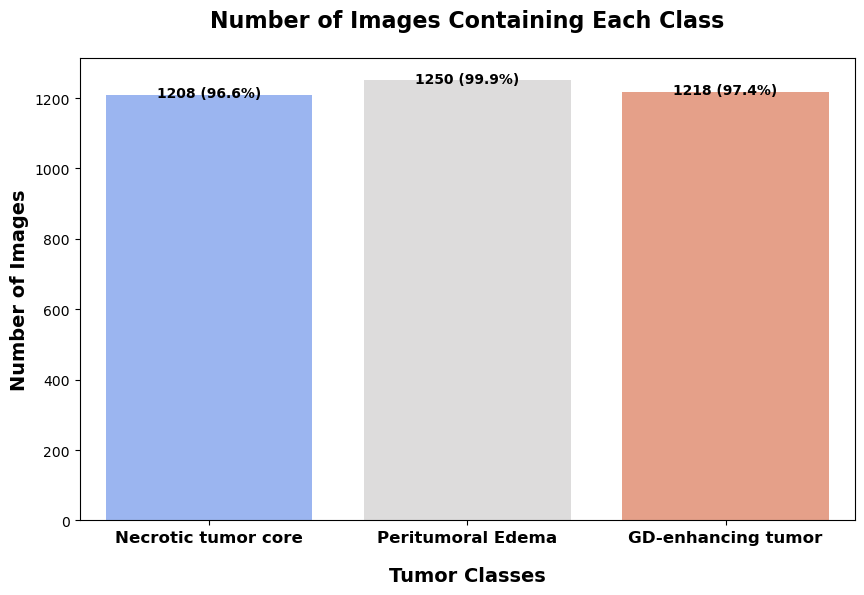

In [37]:
import seaborn as sns

# Подсчёт данных
classes_presence = df[['Necrotic', 'Edema', 'Enhancing']] > 0
count_data = classes_presence.sum()
total_images = len(df)

# Настройка графика
plt.figure(figsize=(10,6))
ax = sns.barplot(x=count_data.index, y=count_data.values, palette="coolwarm")

plt.title('Number of Images Containing Each Class', weight='bold', y=1.05, fontsize=16)
plt.ylabel('Number of Images', weight='bold', fontsize=14)
plt.xlabel('Tumor Classes', weight='bold', fontsize=14, labelpad=15)
labels = ['Necrotic', 'Edema', 'Enhancing']#ax.get_xticks().tolist()
ax.set_xticklabels(labels, weight='bold', fontsize=12)
# Добавление аннотации на каждый bar
for p in ax.patches:
    height = p.get_height()
    percentage = f'{100 * height/total_images:.1f}%'
    ax.text(p.get_x() + p.get_width()/2., height + 5, f'{int(height)} ({percentage})',
            ha='center', va='center', weight='bold')

plt.show()



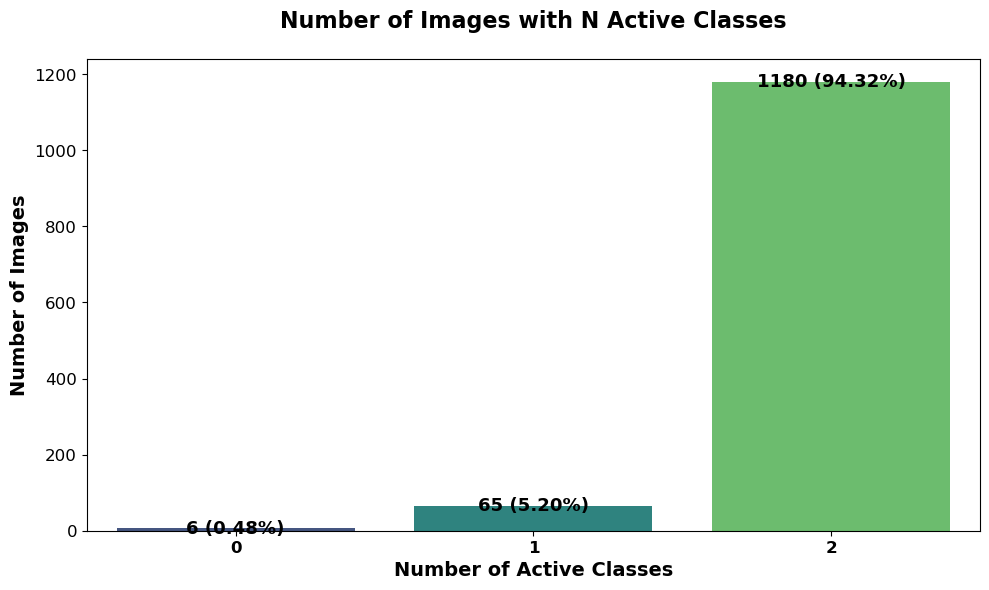

In [294]:
import seaborn as sns
import matplotlib.pyplot as plt

# Подсчет количества активных классов на изображении
df['class_count'] = (df[['Necrotic', 'Edema', 'Enhancing']] > 0).sum(axis=1)
class_counts = df['class_count'].value_counts()

# Подсчет перекрестной информации
necrotic_and_edema = len(df[(df['Necrotic'] > 0) & (df['Edema'] > 0)])
necrotic_and_enhancing = len(df[(df['Necrotic'] > 0) & (df['Enhancing'] > 0)])
edema_and_enhancing = len(df[(df['Edema'] > 0) & (df['Enhancing'] > 0)])

combinations_counts = {
    'Necrotic & Edema': necrotic_and_edema,
    'Necrotic & Enhancing': necrotic_and_enhancing,
    'Edema & Enhancing': edema_and_enhancing
}

# Визуализация
fig, axes = plt.subplots(1, 1, figsize=(10, 6))

# График количества активных классов
sns.barplot(x=class_counts.index, y=class_counts.values, ax=axes, palette="viridis")
axes.set_title('Number of Images with N Active Classes', fontsize=16, weight='bold', y=1.05)
axes.set_xlabel('Number of Active Classes', fontsize=14, weight='bold')
axes.set_ylabel('Number of Images', fontsize=14, weight='bold')

total_images = df.shape[0]
for p in axes.patches:
    height = int(p.get_height())
    percentage = (height / total_images) * 100
    axes.annotate(f'{height} ({percentage:.2f}%)', 
                  (p.get_x() + p.get_width() / 2., height), 
                  ha='center', va='center', 
                  weight='bold', 
                  fontsize=13)

axes.tick_params(axis='x',  labelsize=12)
axes.tick_params(axis='y', labelsize=12, )
labels = axes.get_xticks().tolist()
axes.set_xticklabels(labels, weight='bold', fontsize=12)


plt.tight_layout()
plt.show()


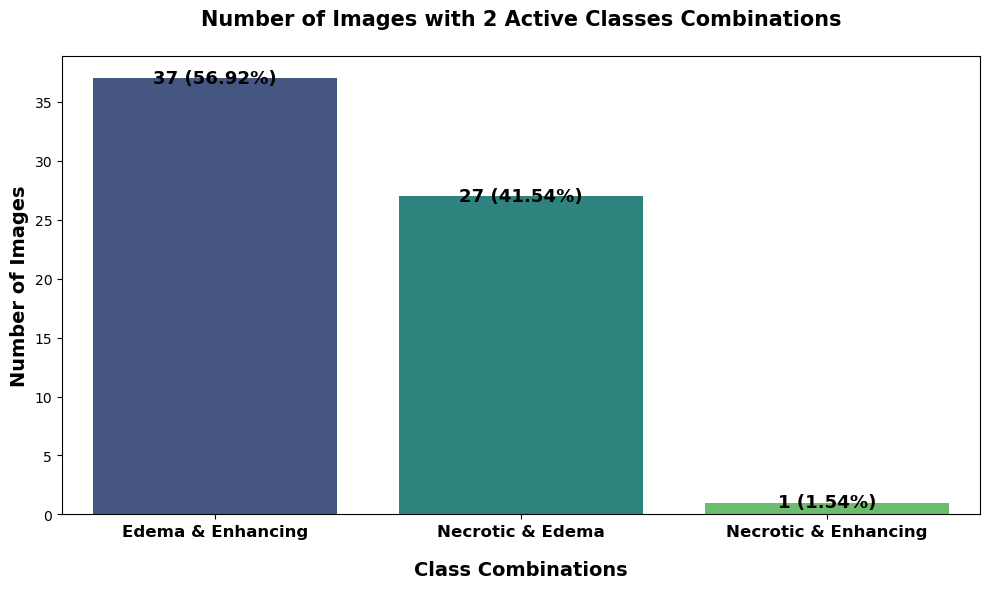

In [305]:
import seaborn as sns
import matplotlib.pyplot as plt

# Отфильтровать изображения, где активно ровно два класса
two_classes_df = df[df['class_count'] == 2]

# Подсчет перекрестной информации для каждой уникальной пары классов
combination_counts_2 = {}

for index, row in two_classes_df.iterrows():
    active_classes = [cls for cls in ['Necrotic', 'Edema', 'Enhancing'] if row[cls] > 0]
    comb_name = ' & '.join(active_classes)
    combination_counts_2[comb_name] = combination_counts_2.get(comb_name, 0) + 1

# Визуализация
plt.figure(figsize=(10,6))

axes = sns.barplot(x=list(combination_counts_2.keys()), y=list(combination_counts_2.values()), palette="viridis")
plt.title('Number of Images with 2 Active Classes Combinations', fontsize=15, weight='bold', y=1.05)
plt.xlabel('Class Combinations', fontsize=14, weight='bold',labelpad=15 )
plt.ylabel('Number of Images', fontsize=14, weight='bold')

total_images_two_classes = len(two_classes_df)
for p in plt.gca().patches:
    height = int(p.get_height())
    percentage = (height / total_images_two_classes) * 100
    plt.gca().annotate(f'{height} ({percentage:.2f}%)', 
                       (p.get_x() + p.get_width() / 2., height), 
                       ha='center', va='center', 
                       weight='bold', 
                       fontsize=13)
labels = combination_counts_2.keys()
axes.set_xticklabels(labels, weight='bold', fontsize=12)

plt.tight_layout()
plt.show()


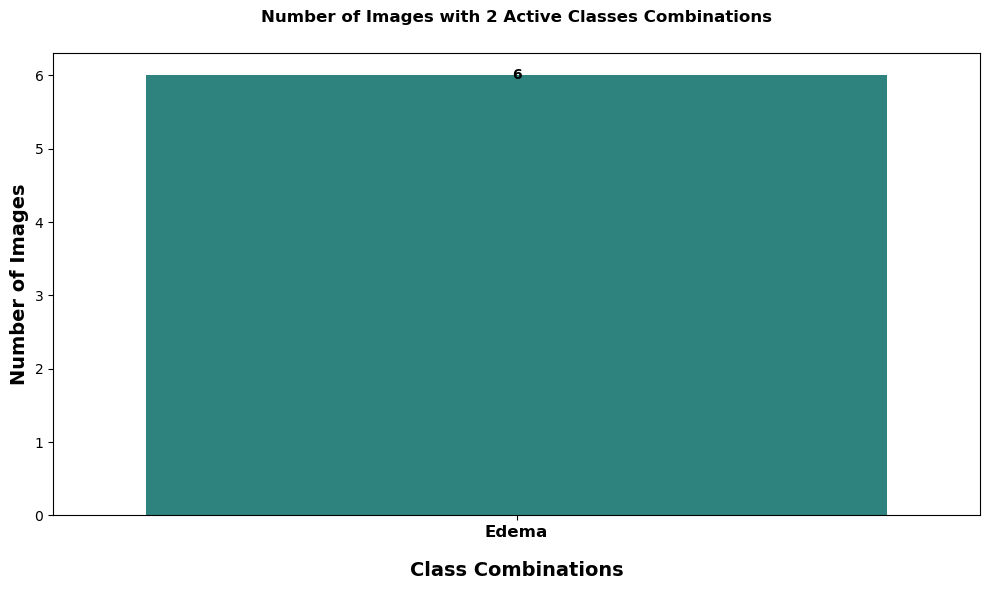

In [306]:
two_classes_df = df[df['class_count'] == 1]
# Подсчет перекрестной информации для каждой уникальной пары классов
combination_counts_2 = {}

for index, row in two_classes_df.iterrows():
    active_classes = [cls for cls in ['Necrotic', 'Edema', 'Enhancing'] if row[cls] > 0]
    comb_name = ' & '.join(active_classes)
    combination_counts_2[comb_name] = combination_counts_2.get(comb_name, 0) + 1

# Визуализация
plt.figure(figsize=(10,6))

axes = sns.barplot(x=list(combination_counts_2.keys()), y=list(combination_counts_2.values()), palette="viridis")
plt.title('Number of Images with 2 Active Classes Combinations', weight='bold', y=1.05)
plt.xlabel('Class Combinations', fontsize=14, weight='bold', labelpad=15)
plt.ylabel('Number of Images', fontsize=14, weight='bold')

for p in plt.gca().patches:
    plt.gca().annotate(int(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', weight='bold')
    
labels = ["Edema"]
axes.set_xticklabels(labels, weight='bold', fontsize=12)
plt.tight_layout()
plt.show()

In [331]:
import nibabel as nib
import numpy as np
from skimage.filters import threshold_otsu

# Загрузка изображения
img = nib.load('/home/mandrakedrink/edu/brats2021/BraTS2021_00124/BraTS2021_00124_t1.nii.gz')
data = img.get_fdata()
threshold_value = threshold_otsu(data)
# Примените пороговое значение для выделения мозга
thresholded_data = (data > threshold_value).astype(int)

# Вычислите объем
voxel_volume = np.prod(img.header.get_zooms())  # Объем одного вокселя
brain_volume = np.sum(thresholded_data) * voxel_volume

print(f"Brain volume: {brain_volume} mm^3")


Brain volume: 1479568.0 mm^3
